## Gaussian process emulation in MCMC

Two radial hamiltonians in Fourier space with square well (SW) and Woods-Saxon (WS) potentials. 

$H_{SW} = T + V_{SW}(R_0,V_0) $

$H_{WS} = T + V_{WS}(R^*_0,V^*_0,a^*_0) $

"Experimental" data is generated by computing low-lying eigenvalues of $H_{WS}$ at fixed parameters. (Pretend that $H_{WS}$ and is "hidden").

Want to use a model $E_{SW}(R_0,V_0)$, low-lying eigenvalues of $H_{SW}$ to approximate experimental data by estimating parameters. Note that no parameterization of the square well will exactly reproduce the Woods-Saxon spectrum, hence the model always has some systematic error.

Parameter estimation: define a posterior distribution for parameters via Bayes' theorem and sample using MCMC.

Solving for the desired eigenvalues of $H_{SW}$ is in general too costly for MCMC, so instead fit a gaussian process regressor (GPR) to the spectrum as it depends on the parameters $(R_0,V_0)$.

The GPR replaces $E_{SW}(R_0,V_0)$ in the likelihood function. Thus we estimate the posterior samples and generate parameter distributions.

Finally, propagate parameter variates through GP to get energy distributions. (Is this just the original likelihood?)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy.linalg as la
from scipy import integrate
from scipy.sparse.linalg import eigsh

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

def fs(k):
    return (1.6*k,k)

In [2]:
#constants
hbar= 1
mass = 1
L = 20
oam = 0
V0 = 50
R0 = 3
a0 = 0.3
n_max = 100
r_dim = 400
# n_space = 1+np.arange(nmax)
n_space = np.arange(n_max)
r_space = np.linspace(0,L,r_dim)

In [3]:
def basis(r,n):
    y = np.sin((n+1)*np.pi*r/L)
    return np.sqrt(2/L)*y

def KE(n):
    z = hbar*np.pi*n/L
    return 0.5*z*z/mass

def KErot(m,n,l):
    z = hbar*hbar*l*(l+1)*np.pi*np.pi*0.5/(mass*L*L)
    return z*min(m,n)

def square_well(r,r0,v0):
    v = np.zeros(r.shape)
    v[r<r0] = -v0
    return v

def woods_saxon(r,r0,v0,a0):
    v = - v0 / (1 + np.exp((r - r0)/a0))
    return v

def inner_product(x,y,space):
    return integrate.simps(x*y,space)
    
def square_well_int(m,n,r0,v0):
    return inner_product(basis(r_space,m),square_well(r_space,r0,v0)*basis(r_space,n),r_space)
    
def woods_saxon_int(m,n,r0,v0,a0):
    return inner_product(basis(r_space,m),woods_saxon(r_space,r0,v0,a0)*basis(r_space,n),r_space)
    
def fourier_to_coord(wfn_f):
    wfn_r = np.sum([wfn_f[k]*basis(r_space,k) for k in n_space],axis=0)
    return wfn_r

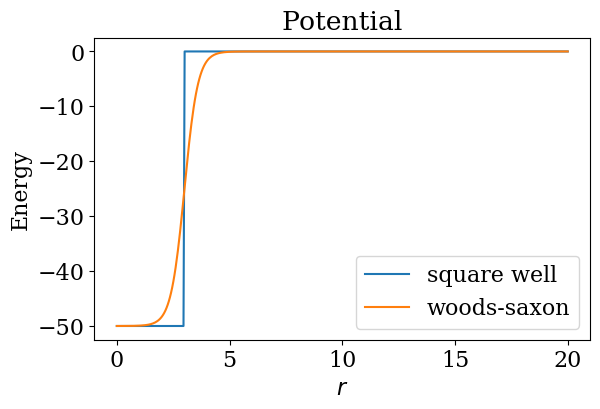

In [4]:
fig = plt.figure(figsize = fs(4),dpi = 100)
plt.plot(r_space,square_well(r_space,R0,V0))
plt.plot(r_space,woods_saxon(r_space,R0,V0,a0))
plt.xlabel(r"$r$")
plt.ylabel("Energy")
plt.title("Potential")
plt.legend(["square well","woods-saxon"])
plt.show()

In [5]:
def make_T():
        T = np.diag(KE(n_space))
        return T

def make_Trot():
    Trot = np.zeros((n_max,n_max))
    for i in range(n_max):
        for j in range(n_max):
            Trot[i,j] = KErot(i,j,oam)
    return Trot
    
def make_V_sw(params):
    try:
        R0, V0 = params
    except:
        raise Exception('SW PARAMS')
    V_square_well = np.zeros((n_max,n_max))    
    for i in range(n_max):
        for j in range(n_max):
            V_square_well[i,j] = square_well_int(i,j,R0,V0)
    return V_square_well
            
def make_V_ws(params):
    try:
        R0, V0, a0 = params
    except:
        raise Exception('WS PARAMS')
    V_woods_saxon = np.zeros((n_max,n_max))
    for i in range(n_max):
        for j in range(n_max):
            V_woods_saxon[i,j] = woods_saxon_int(i,j,R0,V0,a0)
    return V_woods_saxon

def make_H(int_type,params):
    if int_type == 'sw':
        V = make_V_sw(params)
    elif int_type == 'ws':
        V = make_V_ws(params)
    return make_T() + make_Trot() + V

def eigensolve(H,n_keep):
    evals,evecs = la.eig(H)
#     evals,evecs = eigsh(H,k = n_keep, which = 'SM')
    idx = evals.argsort()[::-1]   
    idx = np.flipud(idx)
    evals = evals[idx]
    evecs = evecs[:,idx]
    return evals[:n_keep], evecs[:,:n_keep]

def model(int_type,params,n_keep):
    H = make_H(int_type,params)
    evals, evecs = eigensolve(H,n_keep)
    return evals

def rmse(x,y,dy=1.0):
    return np.sqrt(np.sum(((x-y)/dy)**2)/len(x))

In [6]:
# swme = [square_well_int(1,1,r,V0) for r in np.linspace(0.1,10,100)]
# plt.figure(figsize = (6,6),dpi=100)
# plt.plot(swme)
# plt.show()

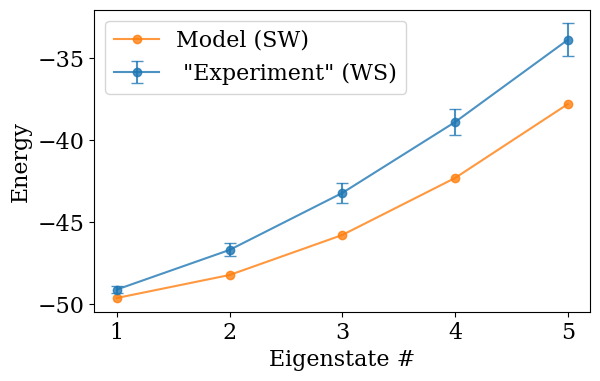

RMSE = 3.815641


In [7]:
# exp_params = [R0, V0, a0]
n_keep = 5
k = 2 # number of params in model


exp_data = model('ws',[R0,V0,a0],n_keep)
exp_unc = np.linspace(0.2,1,exp_data.shape[0])
theory = model('sw',[R0,V0],n_keep)
idx = np.arange(n_keep) + 1

fig = plt.figure(figsize=fs(4),dpi=100)
plt.errorbar(idx,exp_data,exp_unc,marker = "o",label=" \"Experiment\" (WS)", capsize=4, alpha = 0.8)
plt.plot(idx,theory,'-o',label='Model (SW)', alpha = 0.8)
plt.ylabel('Energy')
plt.xlabel('Eigenstate #')
plt.legend()
# plt.legend(['square well','woods saxon'])
plt.show()
print('RMSE = %f' % rmse(exp_data,theory,exp_unc))

In [8]:
from pyDOE import lhs  # latin hypercube sampling

# n_samples = 32
n_samples = 64

def generate_samples_sw_params(n_samples,Rmin,Rmax,Vmin,Vmax):
    Rrange = Rmax - Rmin
    Vrange = Vmax - Vmin
    latin_samples = lhs(2,n_samples)
    X = np.copy(latin_samples)
    X[:,0] = X[:,0]*Rrange + Rmin
    X[:,1] = X[:,1]*Vrange + Vmin
    return X

Rmin = 0.4*R0
Rmax = 1.6*R0
Vmin = 0.6*V0
Vmax = 1.4*V0
X = generate_samples_sw_params(n_samples,Rmin,Rmax,Vmin,Vmax)


(64, 2)


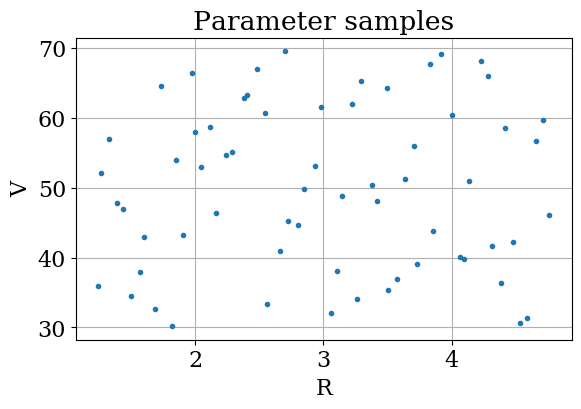

In [9]:
print(X.shape)
fig = plt.figure(figsize=fs(4),dpi=100)
plt.plot(X[:,0],X[:,1],'.')
plt.title("Parameter samples")
plt.xlabel('R')
plt.ylabel('V')
plt.grid()
plt.show()

In [10]:
def run_model(params):
    y = []
    for i in range(n_samples):
        y += [model('sw',params[i,:],n_keep)]
    y = np.array(y)
    return y
y = run_model(X)

In [11]:
X_train = np.copy(X)
y_train = np.copy(y)

In [12]:
X_test = generate_samples_sw_params(n_samples,Rmin,Rmax,Vmin,Vmax)
y_test = run_model(X_test)

In [13]:
# from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.metrics import r2_score

# kernel = DotProduct() + WhiteKernel()
# kernel = RBF(length_scale = 1.)
# kernel = RBF(length_scale = 1.) + DotProduct() + WhiteKernel()
kernel = Matern() 
# kernel = RationalQuadratic()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X_train, y_train) 
# gpr.score(X_train, y_train)
r2_score(gpr.predict(X_train),y_train)


1.0

In [37]:
# dir(gpr)
gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__length_scale': 1.0,
 'kernel__length_scale_bounds': (1e-05, 100000.0),
 'kernel__nu': 1.5,
 'kernel': Matern(length_scale=1, nu=1.5),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

In [14]:
y_pred,y_pred_err = gpr.predict(X_test,return_std = True)

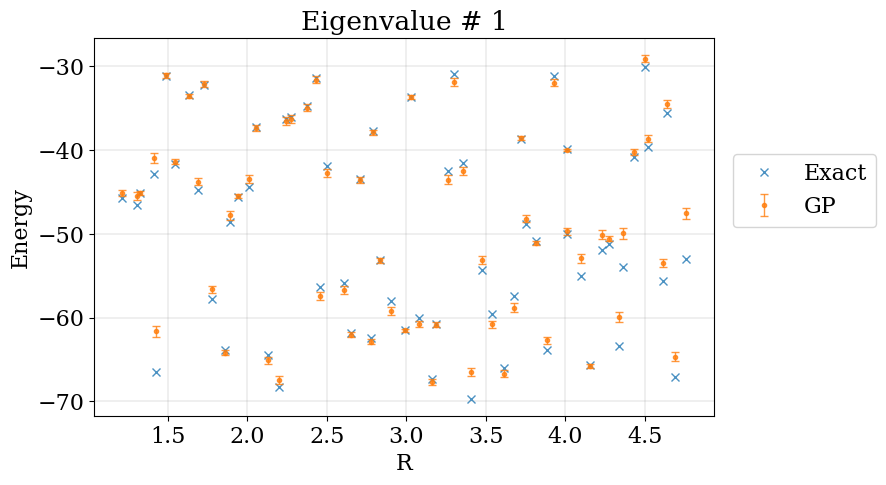

RMSE = 1.479917
R^2 = 0.983860


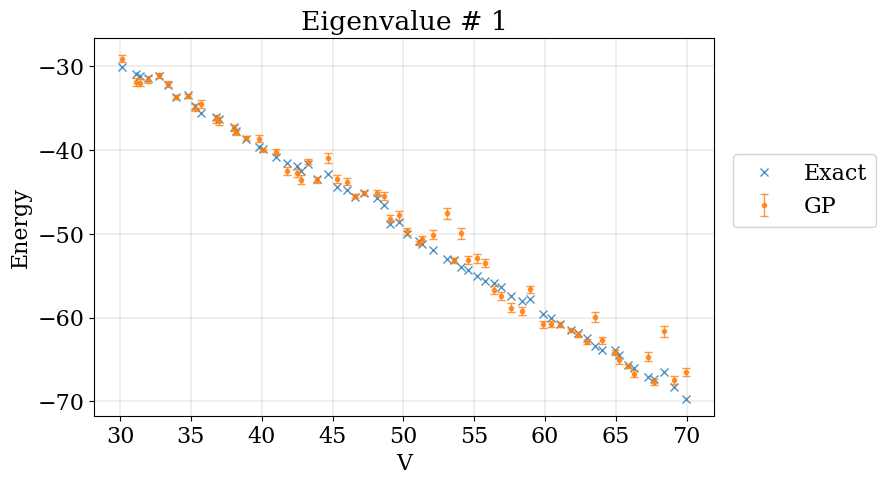

RMSE = 1.479917
R^2 = 0.983860


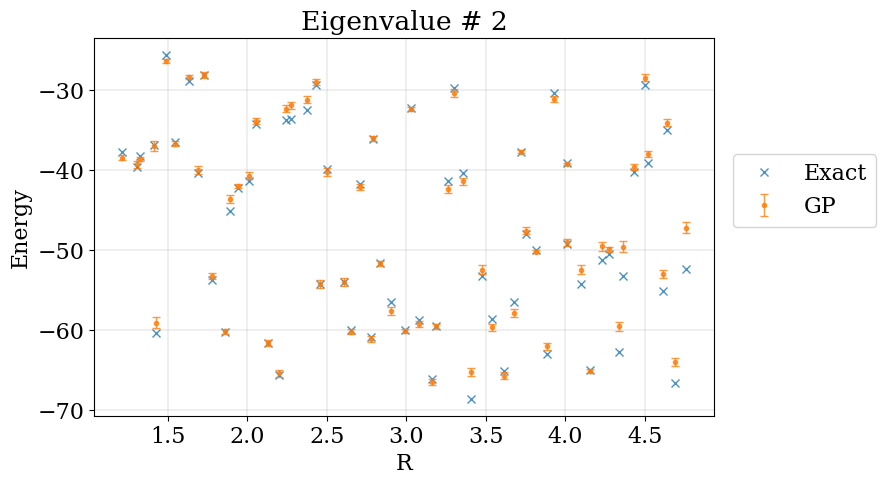

RMSE = 1.295539
R^2 = 0.988505


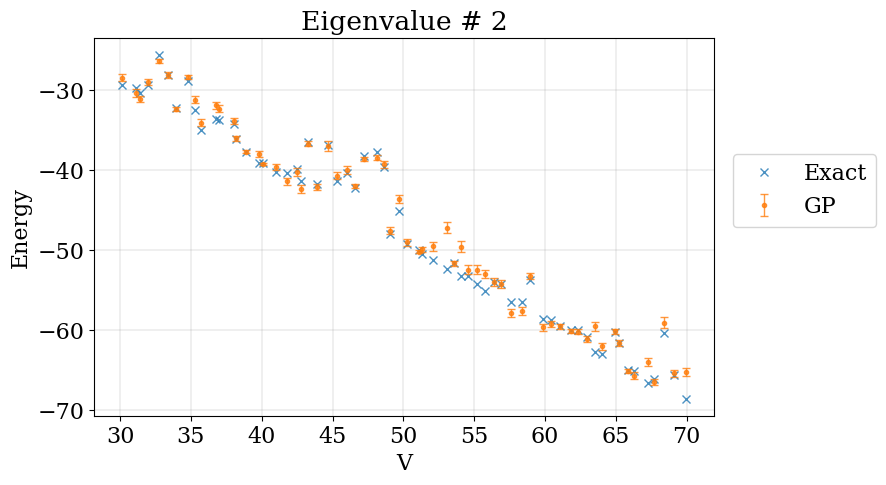

RMSE = 1.295539
R^2 = 0.988505


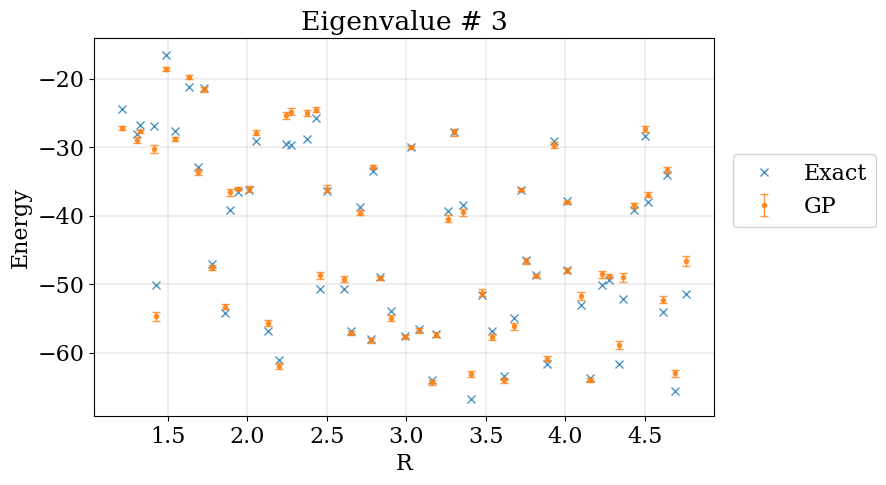

RMSE = 1.795639
R^2 = 0.981876


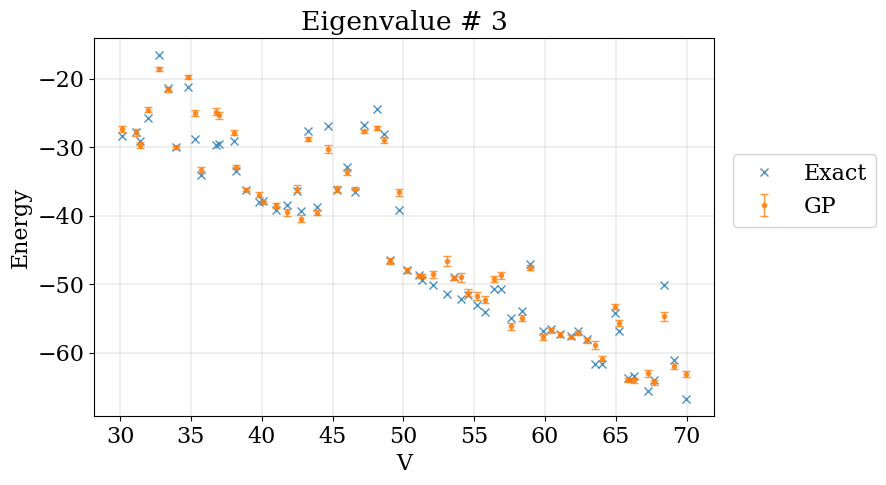

RMSE = 1.795639
R^2 = 0.981876


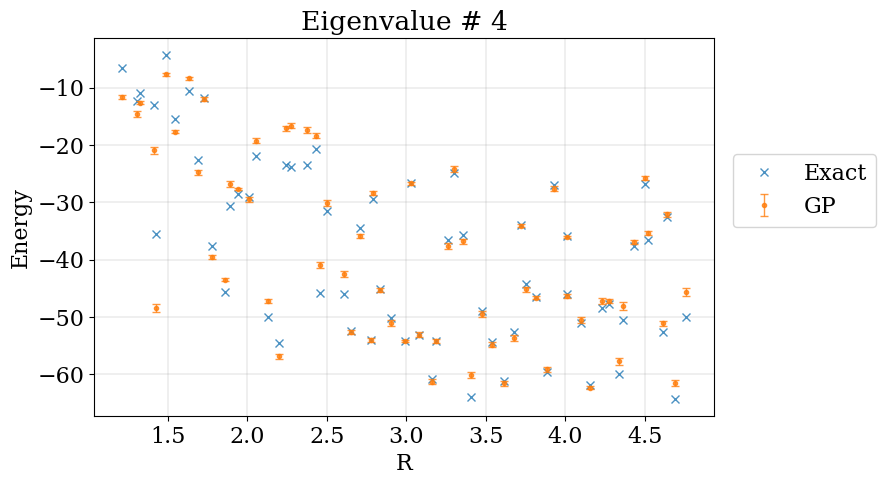

RMSE = 3.007532
R^2 = 0.963919


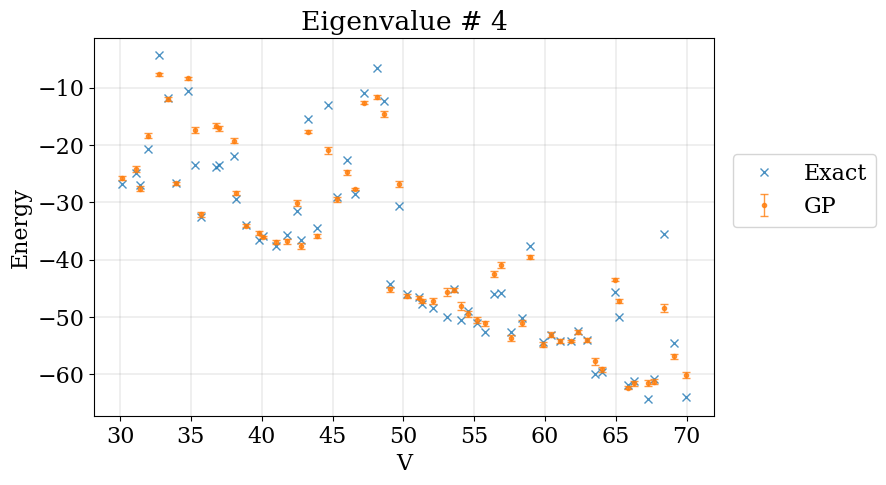

RMSE = 3.007532
R^2 = 0.963919


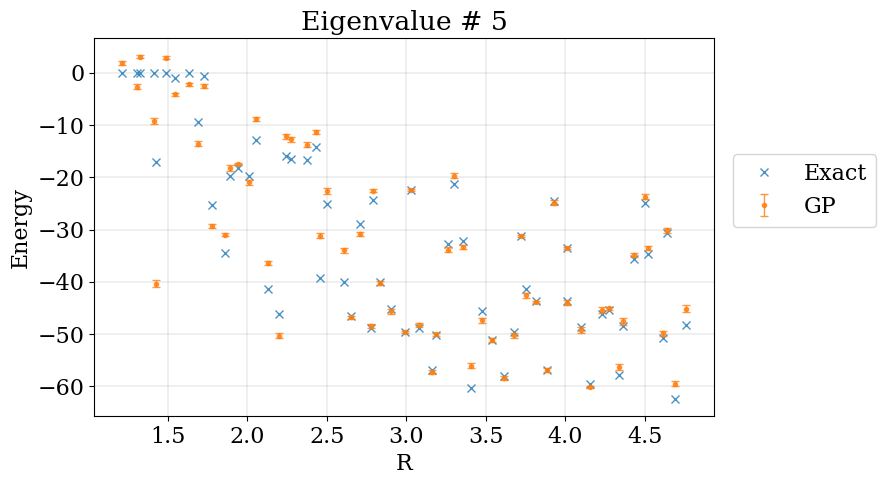

RMSE = 3.946608
R^2 = 0.952754


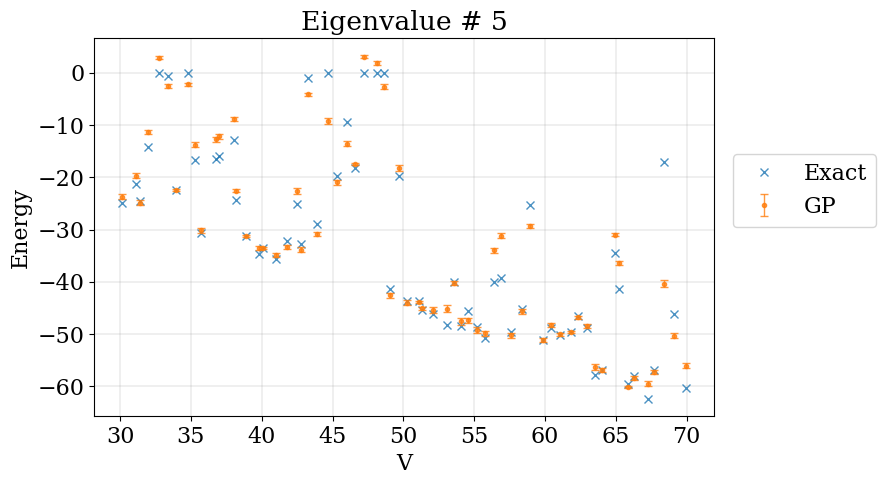

RMSE = 3.946608
R^2 = 0.952754


In [34]:
n_params = X_test.shape[1]
n_features = y_test.shape[1]
label_list = ["R","V"]
for j in range(n_features):
    for i in range(n_params):
        fig = plt.figure(figsize=fs(5),dpi=100)
#         plt.plot(X_train[:,i],y_train,'o')
        plt.plot(X_test[:,i],y_test[:,j],'x',alpha=0.8)
#         plt.plot(X_test[:,i],y_pred[:,j],'P',alpha=0.8)
        plt.errorbar(X_test[:,i],y_pred[:,j],y_pred_err**0.5,marker='.',lw=0,elinewidth=1,alpha=0.8, capsize = 3)    
        plt.legend(['Exact','GP'],loc=(1.03,0.5))
        plt.title("Eigenvalue # %i" % (j+1))
        plt.xlabel(label_list[i])
        plt.ylabel("Energy")
        plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)
        plt.show()
#         print("mean error = %f" % np.mean(y_test[:,j]-y_pred[:,j]))
        print("RMSE = %f" % rmse(y_test[:,j],y_pred[:,j]))
        print("R^2 = %f" % r2_score(y_test[:,j],y_pred[:,j]))
        
    

In [16]:
from scipy import optimize

def log_likelihood(params,n_keep):
#     theory = model('sw',params,n_keep)
#     print(params)
    theory = gpr.predict(np.array(params).reshape((-1,n_params)))
    chi_squared = np.sum( (exp_data - theory)**2 / (exp_unc)**2)
    return   n_keep*( - 0.5 * chi_squared - np.log(np.sqrt(2*np.pi)) ) + np.sum(np.log(exp_unc))

def minfunc(params, n_keep):
    return -log_likelihood(params, n_keep)

result = optimize.minimize(minfunc, x0=[2,50], args=(n_keep), method = 'Nelder-Mead', options = {'disp':True,'maxiter':100})
result

Optimization terminated successfully.
         Current function value: 12.755841
         Iterations: 40
         Function evaluations: 79


 final_simplex: (array([[ 2.65690198, 49.52175401],
       [ 2.65692783, 49.52170841],
       [ 2.65691223, 49.52180801]]), array([12.75584074, 12.75584078, 12.75584097]))
           fun: 12.75584073842699
       message: 'Optimization terminated successfully.'
          nfev: 79
           nit: 40
        status: 0
       success: True
             x: array([ 2.65690198, 49.52175401])

In [17]:
def multivariate_uniform_pdf(x,dim,limits):
    const = np.product([(lim[1]-lim[0]) for lim in limits])**(-1.0*dim)
    check = all([(x[i]>limits[i][0] and x[i]<limits[i][1]) for i in range(dim)])
    val = 0.
    if check:
        val = const
    return val

In [18]:
def log_prior_normal(params,mu,sigma):
    # log normal
    return -np.sum([0.5* (params[i] - mu[i])**2 / sigma[i]**2 for i in range(k)]) - np.sum(np.sqrt(2*np.pi*sigma))
    
def log_prior_uniform(params,limits):
    dim = len(params)
    with np.errstate(divide='ignore'):
        return np.log(multivariate_uniform_pdf(params,dim,limits))

# def log_posterior(params, prior_mu, prior_sigma, n_keep):
#     return log_prior_normal(params, np.array(prior_mu), np.array(prior_sigma)) + log_likelihood(params, n_keep)/n_keep

def log_posterior(params, n_keep):
    prior_mu, prior_sigma = ([2,50],[10,100])
    return log_prior_normal(params, np.array(prior_mu), np.array(prior_sigma)) + log_likelihood(params, n_keep)/n_keep

# def log_posterior(params, n_keep):
#     limits = [[0.1,7],[10,200]]
#     return log_prior_uniform(params, limits) + log_likelihood(params, n_keep)/n_keep

In [19]:
import emcee
print('emcee sampling (version: )', emcee.__version__)

ndim = k  # kmax+1
nwalkers = 50  # number of MCMC walkers
nsteps = 5000 # steps per walker
# dtheta = 0.5*np.ones(ndim)    # parameters for prior

print(f'{nwalkers} walkers: {nsteps} samples each')
# print('prior sigmas = '+str(dtheta))

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[n_keep])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
Wall time: 43.2 s
done


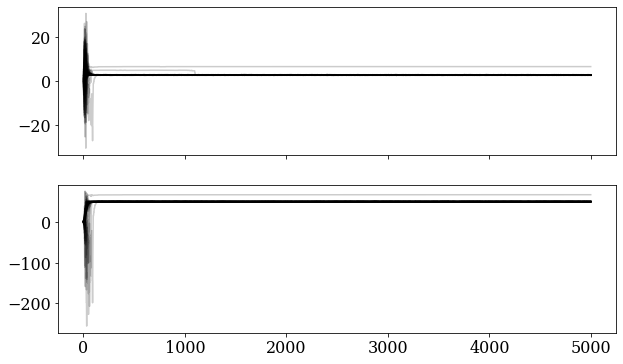

In [20]:
fig, ax = plt.subplots(ndim, sharex=True,figsize=(10,6))
for i in range(ndim):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

In [21]:
# We choose a warm-up time
nwarmup = 500 # warm up

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the warmup points and reshape:
emcee_trace = sampler.chain[:, nwarmup:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nwarmup:].reshape(-1).T

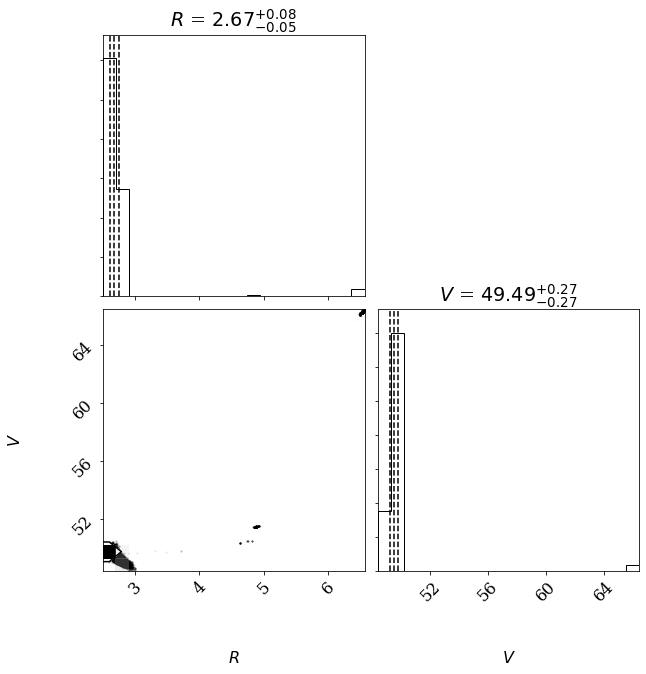

In [22]:
# Alternatively we can use corner
import corner
fig, ax = plt.subplots(ndim,ndim, figsize=(10,10))

def label_func():
    label_list=[r'$R$',r'$V$']
    return label_list

label_list = label_func()
corner.corner(emcee_trace.T,labels=label_list,
                       quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True
                       );

In [28]:
emcee_trace_trunc = np.copy(emcee_trace)
emcee_trace_trunc = emcee_trace_trunc[:,emcee_trace_trunc[1,:]<52]
emcee_trace_trunc = emcee_trace_trunc[:,emcee_trace_trunc[0,:]<3.25]

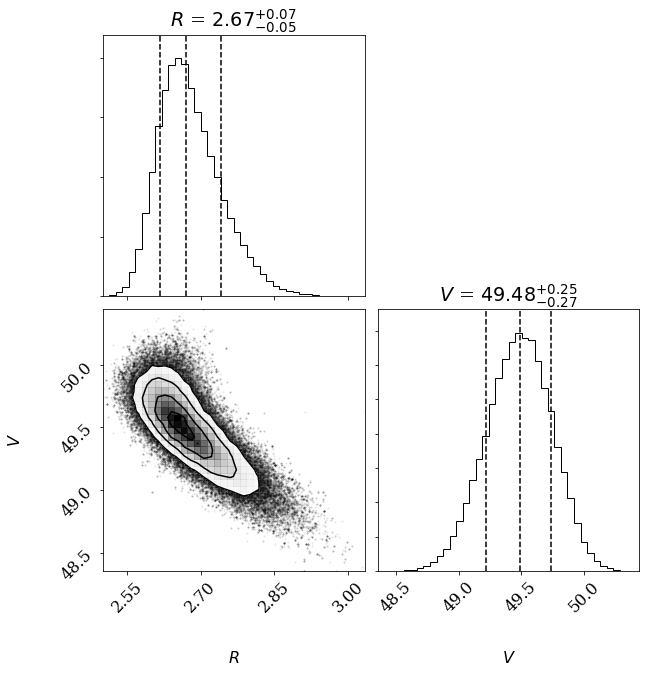

In [29]:
# Alternatively we can use corner
# import corner
fig, ax = plt.subplots(ndim,ndim, figsize=(10,10))

label_list = label_func()
corner.corner(emcee_trace_trunc.T,
              labels=label_list,
              quantiles=[0.16, 0.5, 0.84],
              fig=fig,
              show_titles=True,
              bins=40
             );

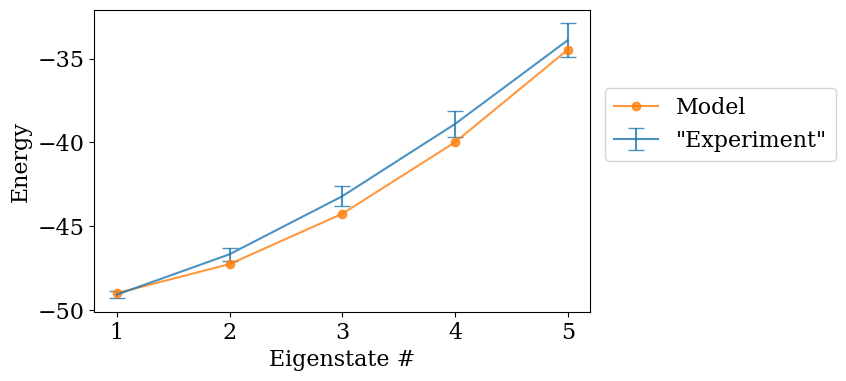

RMSE = 1.231085


In [30]:
theory = model('sw',[2.67,49.5],n_keep)
idx = np.arange(n_keep) + 1
fig = plt.figure(figsize=fs(4),dpi=100)
plt.errorbar(idx,exp_data,exp_unc,label="\"Experiment\"",alpha = 0.8, capsize = 6)
plt.plot(idx,theory,'-o',label='Model',alpha = 0.8)
plt.ylabel('Energy')
plt.xlabel('Eigenstate #')
plt.legend(loc = (1.03,0.5))
# plt.legend(['square well','woods saxon'])
plt.show()
print('RMSE = %f' % rmse(exp_data,theory,exp_unc))

In [31]:
# propagation
prop_set = gpr.predict(emcee_trace_trunc.T)

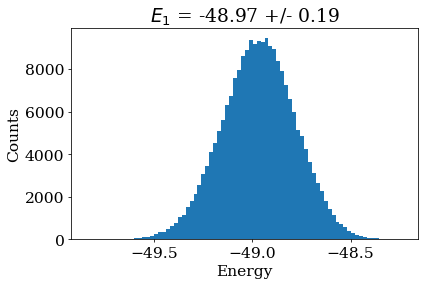

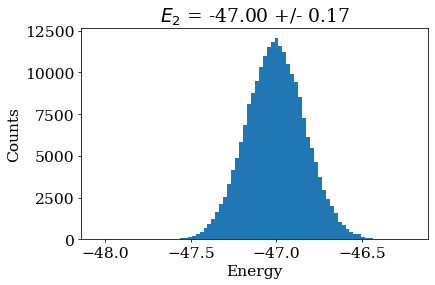

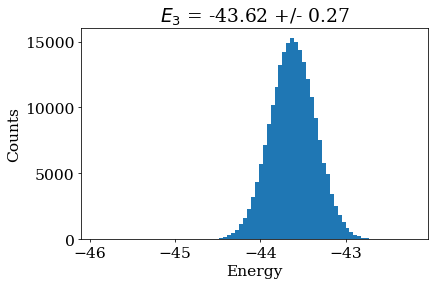

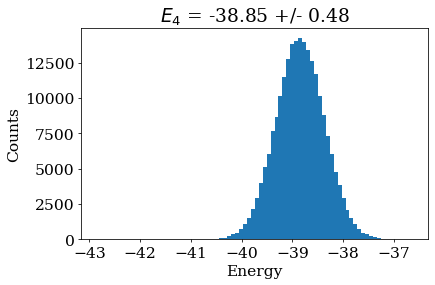

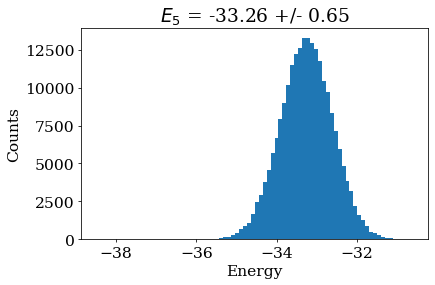

In [32]:
for i in range(n_features):
    fig = plt.figure(figsize=fs(4),dpi=70)
    plt.hist(prop_set[:,i], bins = 80)
    mu = np.mean(prop_set[:,i])
    sigma = np.std(prop_set[:,i])
    
    plt.title(r"$E_{%i}$ = %3.2f +/- %3.2f" % (i+1,mu,sigma))
    plt.xlabel("Energy")
    plt.ylabel("Counts")
    plt.show()

In [38]:
model('sw',[2.67,49.5],n_keep)

array([-49.00991916, -47.27366997, -44.26699541, -39.99530836,
       -34.46964471])